# Problem Set 3: Policy Text Classification w/ Open Source LLMs - SOLUTION

**Dataset**: Option A - National Climate Targets  
**Model**: GPT-2 (124M)  
**Task**: Multi-label classification (3 classes)
## Introduction

This notebook demonstrates the complete workflow for climate policy text classification:
1. Data loading and exploration
2. Zero-shot evaluation with prompt engineering
3. Few-shot evaluation
4. LoRA fine-tuning
5. Comprehensive error analysis

**Note**: This solution uses Option A (Climate Targets). Option B (TCFD) follows
the same structure with different dataset/model configuration.

## Setup and Installation

In [1]:
# Install required libraries
# !pip install datasets transformers torch peft accelerate evaluate scikit-learn

import gc

import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    hamming_loss,
    jaccard_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
Using device: cuda


### Helper function for clearing mem / avoiding OOM

In [2]:
# Memory management helper
def clear_memory():
    """Safely clear GPU memory."""

    # Try to delete common large objects
    for obj_name in ['generator', 'model', 'trainer', 'climate_model']:
        try:
            if obj_name in globals():
                del globals()[obj_name]
        except:
            pass

    torch.cuda.empty_cache()
    gc.collect()

    # Print memory stats
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        print(f"GPU Memory cleared: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")

## Configuration: Dataset Choice

This solution demonstrates Option A (National Climate Targets with GPT-2).

In [3]:
# Configuration for Option A: National Climate Targets
DATASET_NAME = "ClimatePolicyRadar/national-climate-targets"
MODEL_NAME = "gpt2"
TARGET_MODULES = ['c_attn', 'c_proj']
IS_MULTILABEL = True
NUM_LABELS = 3
LABEL_NAMES = ['Net Zero', 'Reduction', 'Other']
NUM_EPOCHS = 10
EVAL_SAMPLES = 100

print(f"="*80)
print(f"Configuration:")
print(f"  Dataset: {DATASET_NAME}")
print(f"  Model: {MODEL_NAME}")
print(f"  Task: {'Multi-label' if IS_MULTILABEL else 'Single-label'} ({NUM_LABELS} classes)")
print(f"  Labels: {LABEL_NAMES}")
print(f"  Device: {device}")
print(f"="*80)

Configuration:
  Dataset: ClimatePolicyRadar/national-climate-targets
  Model: gpt2
  Task: Multi-label (3 classes)
  Labels: ['Net Zero', 'Reduction', 'Other']
  Device: cuda


---
# Task 1: Data Loading and Exploration (10 points)

Load the dataset, understand its structure, and visualize label distributions.

In [4]:
# Load dataset
print(f"\nLoading dataset: {DATASET_NAME}...")
dataset = load_dataset(DATASET_NAME)

print(f"\nDataset structure:")
print(dataset)


Loading dataset: ClimatePolicyRadar/national-climate-targets...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2610 [00:00<?, ? examples/s]


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'annotation_agent', 'geography', 'region', 'translated', 'annotation_NZT', 'annotation_Reduction', 'annotation_Other'],
        num_rows: 2610
    })
})


Need to wrangle multilabel format

In [5]:
# Prepare multi-label format
def prepare_multilabel(example):
    """Convert annotation columns to label list."""
    example['labels'] = [
        float(example['annotation_NZT']),
        float(example['annotation_Reduction']),
        float(example['annotation_Other'])
    ]
    return example

dataset = dataset['train'].map(prepare_multilabel)

print(f"  Total samples: {len(dataset)}")

Map:   0%|          | 0/2610 [00:00<?, ? examples/s]

  Total samples: 2610


In [6]:
# Create train/val/test splits

# First split: 85% train+val, 15% test
train_val_test = dataset.train_test_split(test_size=0.15, seed=SEED)
train_val = train_val_test['train']
test_dataset = train_val_test['test']

# Second split: 85% train, 15% val (from train_val)
train_val_split = train_val.train_test_split(test_size=0.176, seed=SEED)  # 0.176 * 0.85 ≈ 0.15 of total
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

print(f"\nSplits created:")
print(f"  Train: {len(train_dataset):4d} samples ({len(train_dataset)/len(dataset)*100:.1f}%)")
print(f"  Val:   {len(val_dataset):4d} samples ({len(val_dataset)/len(dataset)*100:.1f}%)")
print(f"  Test:  {len(test_dataset):4d} samples ({len(test_dataset)/len(dataset)*100:.1f}%)")



Splits created:
  Train: 1827 samples (70.0%)
  Val:    391 samples (15.0%)
  Test:   392 samples (15.0%)


LABEL DISTRIBUTION

    Label  Train Count   Train %  Test Count    Test %
 Net Zero          136  7.443897          33  8.418367
Reduction          233 12.753147          63 16.071429
    Other          445 24.356869          85 21.683673

Labels per sample (train):
  Mean: 0.45
  Min:  0
  Max:  3


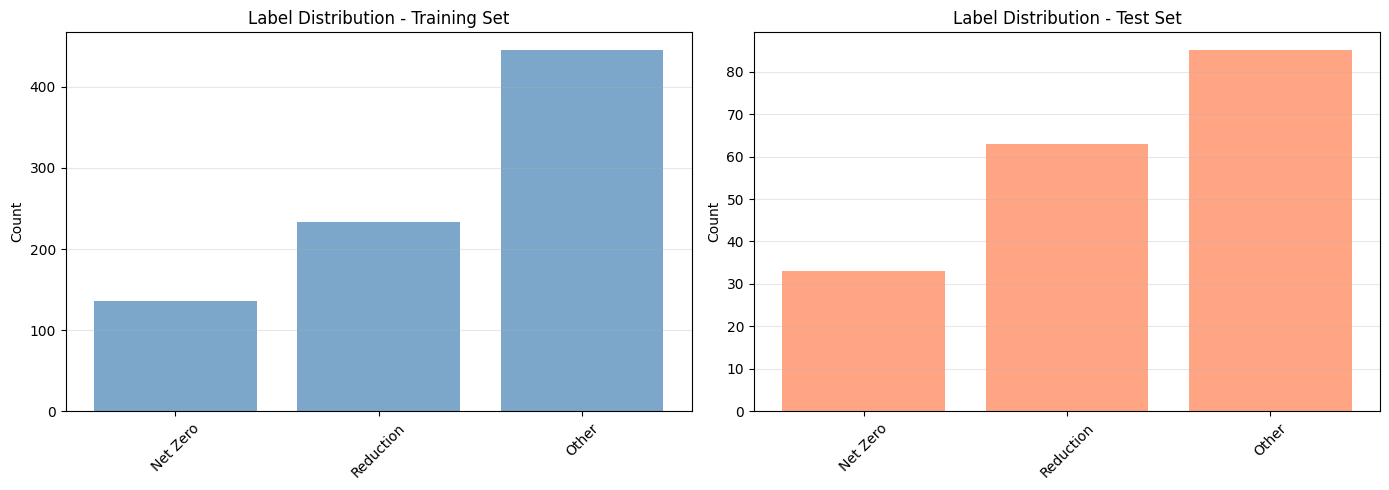

In [7]:
# Analyse label distribution

print("LABEL DISTRIBUTION")

# Count label frequencies
train_labels_array = np.array([ex['labels'] for ex in train_dataset])
test_labels_array = np.array([ex['labels'] for ex in test_dataset])

train_counts = train_labels_array.sum(axis=0)
test_counts = test_labels_array.sum(axis=0)

# Create distribution table
dist_df = pd.DataFrame({
    'Label': LABEL_NAMES,
    'Train Count': train_counts.astype(int),
    'Train %': train_counts / len(train_dataset) * 100,
    'Test Count': test_counts.astype(int),
    'Test %': test_counts / len(test_dataset) * 100
})

print("\n" + dist_df.to_string(index=False))

# Calculate multi-label statistics
train_labels_per_sample = train_labels_array.sum(axis=1)
print(f"\nLabels per sample (train):")
print(f"  Mean: {train_labels_per_sample.mean():.2f}")
print(f"  Min:  {int(train_labels_per_sample.min())}")
print(f"  Max:  {int(train_labels_per_sample.max())}")

# Visualise
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(LABEL_NAMES, train_counts, alpha=0.7, color='steelblue')
axes[0].set_ylabel('Count')
axes[0].set_title('Label Distribution - Training Set')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(LABEL_NAMES, test_counts, alpha=0.7, color='coral')
axes[1].set_ylabel('Count')
axes[1].set_title('Label Distribution - Test Set')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

NB: Multi-label classification - texts can have 0, 1, 2, or all 3 labels!
Also, NB: imbalance classes

### Show some example texts

In [8]:
# Show examples with different label combinations
examples_to_show = [
    (1, 0, 0),  # Only Net Zero
    (0, 1, 0),  # Only Reduction
    (0, 0, 1),  # Only Other
    (1, 1, 0),  # Net Zero + Reduction
    (1, 1, 1),  # All three
]

shown = 0
for target_labels in examples_to_show:
    for ex in train_dataset:
        if tuple(ex['labels']) == target_labels and shown < 5:
            labels_present = [LABEL_NAMES[i] for i, val in enumerate(ex['labels']) if val == 1]

            print(f"\n{'='*80}")
            print(f"Example {shown + 1}: {' + '.join(labels_present) if labels_present else 'No labels'}")
            print(f"{'='*80}")
            print(f"Text: {ex['text'][:400]}...")
            print(f"\nLabels: {labels_present}")

            shown += 1
            break

    if shown >= 5:
        break


Example 1: Net Zero
Text: As for attracting funds from the private sector, we will promote the development of financial market rules, such as standards for information disclosure and evaluation, in cooperation with other countries. Carbon neutrality by 2050 is an extremely difficult task, requiring more ambitious innovation challenges than ever before. For particularly important projects, after sharing ambitious and specif...

Labels: ['Net Zero']

Example 2: Reduction
Text: In November 2015 the country submitted its proposal to the UNFCCC for a national contribution to reduce GHG emissions ("Intended Nationally Determined Contribution (INDC) of the Republic of Angola"), where it proposes to unconditionally reduce its GHG emissions by 35% by 2030 compared to the baseline scenario (base year 2005), and also, through international funding, reduce a further 15% of its GH...

Labels: ['Reduction']

Example 3: Other
Text:  Energy sector is the largest producer of greenhouse gas emissions a


Text length statistics (tokens):
  Mean:   159.8
  Median: 133.0
  Min:    7
  Max:    416


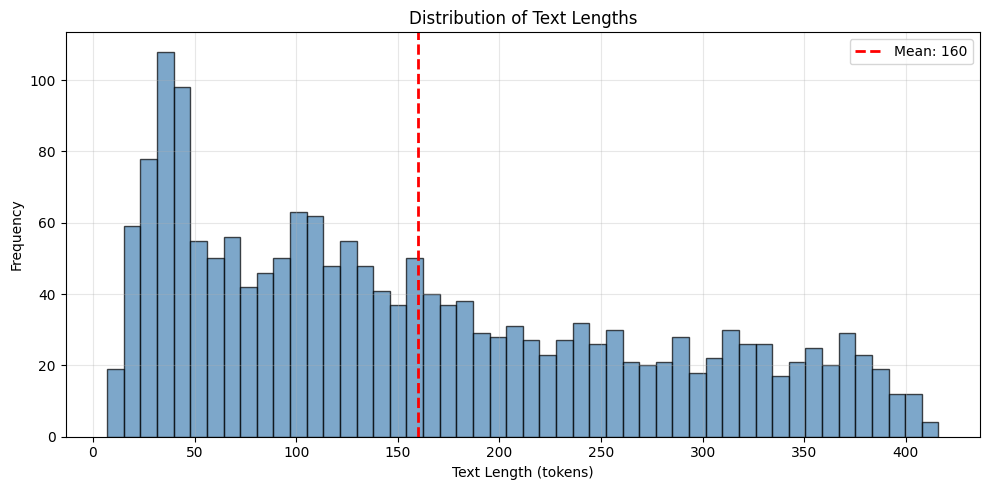

In [9]:
# Text length analysis
train_texts = [ex['text'] for ex in train_dataset]
text_lengths = [len(text.split()) for text in train_texts]

print(f"\nText length statistics (tokens):")
print(f"  Mean:   {np.mean(text_lengths):.1f}")
print(f"  Median: {np.median(text_lengths):.1f}")
print(f"  Min:    {np.min(text_lengths)}")
print(f"  Max:    {np.max(text_lengths)}")

# Visualize
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Text Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.axvline(np.mean(text_lengths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(text_lengths):.0f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Possible point to discuss in eval is that token length of some prompts may well be too long for smaller models. Esp for few-shot prompts.

---
# Task 2: Zero-Shot Evaluation (15 points)

Test the model without training using different prompt strategies.

In [10]:
# Load tokenizer and generator
print(f"\nLoading model: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

generator = pipeline(
    "text-generation",
    model=MODEL_NAME,
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else -1,
    max_new_tokens=25,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)


Loading model: gpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Define a programmatic prompting template

In [11]:
# define prompt templates

PROMPTS = {
    'direct': """Text: {text}

Which climate targets are mentioned? (Net Zero, Reduction, Other, or None)
Answer:""",

    'explicit_multilabel': """Analyze this climate policy text and identify ALL target types present (multiple may apply).

Text: {text}

Mark each as YES or NO:
Net Zero: [  ]
Reduction: [  ]
Other: [  ]

Answer:""",

    'detailed_definitions': """Identify climate targets in this text. Multiple types can be present.

DEFINITIONS:
- Net Zero: Commitment to balance greenhouse gas emissions with removals, achieving carbon neutrality by a specific year (e.g., "reach net-zero by 2050")
- Reduction: Specific percentage or absolute decrease in emissions by a target date (e.g., "reduce emissions by 40% by 2030")
- Other: Renewable energy targets, energy efficiency goals, or other quantifiable climate objectives that aren't emission reductions (e.g., "80% renewable electricity by 2035")

Text: {text}

Which targets are present (list all that apply):""",

    'chain_of_thought': """Analyze this policy text step-by-step to identify climate targets.

Text: {text}

Analysis:
1. Check for net-zero or carbon neutrality commitments → Net Zero?
2. Check for emission reduction percentages or amounts → Reduction?
3. Check for renewable energy, efficiency, or other goals → Other?

Conclusion - Targets present:""",

    'structured_json': """Extract climate target information from this policy text.

Text: {text}

Return your analysis in this format:
{{
  "Net Zero": "[YES/NO] - carbon neutrality commitments",
  "Reduction": "[YES/NO] - emission reduction percentages",
  "Other": "[YES/NO] - renewables/efficiency/other goals"
}}

Answer:""",

    'keyword_checklist': """Read the text and check for these climate target indicators:

Text: {text}

CHECKLIST:
[ ] Net Zero? Look for: "net zero", "carbon neutral", "climate neutral", "neutrality by [year]"
[ ] Reduction? Look for: "reduce by X%", "cut emissions", "decrease", "lower by"
[ ] Other? Look for: "renewable energy", "clean energy", "efficiency target", "renewables"

Targets identified (check all that apply):""",

    'binary_questions': """Answer YES or NO for each climate target type in this text:

Text: {text}

Q1: Does this text contain a Net Zero target (commitment to carbon neutrality by specific year)?
A1:

Q2: Does this text contain a Reduction target (specific emission decrease percentage or amount)?
A2:

Q3: Does this text contain Other targets (renewable energy, efficiency, or non-emission goals)?
A3:

Final answer - Present targets:""",

    'indicator_based': """Identify climate targets by recognizing key indicators in the text.

Text: {text}

INDICATORS TO LOOK FOR:

Net Zero indicators:
- Words like "net zero", "carbon neutral", "neutrality"
- Phrases about balancing emissions with removals
- Commitments to specific "neutrality by [year]"

Reduction indicators:
- Percentage symbols with years: "X% by 20XX"
- Action verbs: "reduce", "cut", "decrease", "lower"
- Phrases like "emission reductions", "cutting carbon"

Other indicators:
- "renewable energy", "clean energy", "renewables target"
- "energy efficiency", "efficiency improvements"
- Technology targets: "solar", "wind", "electric vehicles"

Which target types are present:""",
}

print(f"\nCreated {len(PROMPTS)} ZERO-SHOT prompt templates")
print("\nPrompt strategies tested:")
for i, name in enumerate(PROMPTS.keys(), 1):
    print(f"  {i:2d}. {name}")


Created 8 ZERO-SHOT prompt templates

Prompt strategies tested:
   1. direct
   2. explicit_multilabel
   3. detailed_definitions
   4. chain_of_thought
   5. structured_json
   6. keyword_checklist
   7. binary_questions
   8. indicator_based


Need a parsing fn to assign class based on model's generative output

In [12]:
def parse_output(generated_text):
    """
    Parse various zero-shot output formats.
    Returns: [0/1, 0/1, 0/1] for [Net Zero, Reduction, Other]
    """
    text_lower = generated_text.lower()
    labels = [0, 0, 0]

    # Method 1: Check for explicit YES/NO format
    # "Net Zero: YES" or "Net Zero: [YES]" or "A1: YES"
    if any(pattern in text_lower for pattern in [
        'net zero: yes', 'net zero: [yes]', 'net-zero: yes',
        'a1: yes', 'q1: yes'
    ]):
        labels[0] = 1

    if any(pattern in text_lower for pattern in [
        'reduction: yes', 'reduction: [yes]',
        'a2: yes', 'q2: yes'
    ]):
        labels[1] = 1

    if any(pattern in text_lower for pattern in [
        'other: yes', 'other: [yes]',
        'a3: yes', 'q3: yes'
    ]):
        labels[2] = 1

    # Method 2: Check for explicit mentions in list format
    # "Targets present: Net Zero, Reduction"
    list_section = text_lower.split('targets')[-1] if 'targets' in text_lower else text_lower
    list_section = list_section.split('conclusion')[-1] if 'conclusion' in list_section else list_section
    list_section = list_section.split('answer')[-1] if 'answer' in list_section else list_section

    if 'net zero' in list_section or 'net-zero' in list_section or 'netzero' in list_section:
        labels[0] = 1
    if 'reduction' in list_section:
        labels[1] = 1
    if 'other' in list_section:
        labels[2] = 1

    # Method 3: Check for indicator keywords (only if no explicit format found)
    if sum(labels) == 0:
        # Net Zero keywords
        if any(kw in text_lower for kw in [
            'net zero', 'net-zero', 'carbon neutral', 'climate neutral',
            'neutrality by', 'achieve neutrality'
        ]):
            labels[0] = 1

        # Reduction keywords
        if any(kw in text_lower for kw in [
            'reduce by', 'reduction', 'cut emissions', 'decrease',
            '% by', 'percent by'
        ]):
            labels[1] = 1

        # Other keywords
        if any(kw in text_lower for kw in [
            'renewable', 'clean energy', 'efficiency target',
            'solar', 'wind'
        ]):
            labels[2] = 1

    # Method 4: Check for explicit NO to override
    if 'net zero: no' in text_lower or 'a1: no' in text_lower:
        labels[0] = 0
    if 'reduction: no' in text_lower or 'a2: no' in text_lower:
        labels[1] = 0
    if 'other: no' in text_lower or 'a3: no' in text_lower:
        labels[2] = 0

    # Method 5: Check for "none" to clear all
    if 'none' in list_section and sum(labels) == 0:
        labels = [0, 0, 0]

    return labels

print("\nHandles multiple output formats:")
print("  - YES/NO binary answers")
print("  - Comma-separated lists")
print("  - JSON-like format")
print("  - Q&A format (A1:, A2:, A3:)")
print("  - Free-form text with keywords")


Handles multiple output formats:
  - YES/NO binary answers
  - Comma-separated lists
  - JSON-like format
  - Q&A format (A1:, A2:, A3:)
  - Free-form text with keywords


In [13]:
# Sample test data for evaluation
test_sample = test_dataset.shuffle(seed=SEED).select(range(min(EVAL_SAMPLES, len(test_dataset))))
print(f"\nTest samples: {len(test_sample)} examples")


Test samples: 100 examples


In [14]:
# Evaluate zero-shot with each prompt

zero_shot_results = {}

for prompt_name, prompt_template in PROMPTS.items():
    print(f"\n--- Evaluating '{prompt_name}' prompt ---")

    predictions = []
    true_labels = []

    for i, example in enumerate(test_sample):
        if (i + 1) % 20 == 0:
            print(f"  Processing {i+1}/{len(test_sample)}...", end='\r')

        # Create prompt (truncate text to prevent overflow)
        text = example['text'][:300]
        prompt = prompt_template.format(text=text)

        try:
            output = generator(prompt, max_new_tokens=25, truncation=True)
            response = output[0]['generated_text'][len(prompt):].strip()
            pred = parse_output(response)
        except Exception as e:
            # If generation fails, predict no labels
            pred = [0, 0, 0]

        predictions.append(pred)
        true_labels.append(example['labels'])

    print(f"  Processing {len(test_sample)}/{len(test_sample)}... Done!")

    # Calculate metrics
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    accuracy = accuracy_score(true_labels, predictions)
    f1_macro = f1_score(true_labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(true_labels, predictions, average='weighted', zero_division=0)
    hamming = hamming_loss(true_labels, predictions)
    jaccard = jaccard_score(true_labels, predictions, average='samples', zero_division=0)

    zero_shot_results[prompt_name] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'hamming': hamming,
        'jaccard': jaccard
    }

    print(f"  Accuracy:      {accuracy:.3f}")
    print(f"  F1 (macro):    {f1_macro:.3f}")
    print(f"  Hamming Loss:  {hamming:.3f}")
    print(f"  Jaccard:       {jaccard:.3f}")

# Clean up generator
clear_memory()


--- Evaluating 'direct' prompt ---


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  Processing 100/100... Done!
  Accuracy:      0.440
  F1 (macro):    0.117
  Hamming Loss:  0.303
  Jaccard:       0.028

--- Evaluating 'explicit_multilabel' prompt ---
  Processing 100/100... Done!
  Accuracy:      0.520
  F1 (macro):    0.109
  Hamming Loss:  0.223
  Jaccard:       0.035

--- Evaluating 'detailed_definitions' prompt ---
  Processing 100/100... Done!
  Accuracy:      0.340
  F1 (macro):    0.185
  Hamming Loss:  0.270
  Jaccard:       0.073

--- Evaluating 'chain_of_thought' prompt ---
  Processing 100/100... Done!
  Accuracy:      0.500
  F1 (macro):    0.130
  Hamming Loss:  0.213
  Jaccard:       0.035

--- Evaluating 'structured_json' prompt ---
  Processing 100/100... Done!
  Accuracy:      0.320
  F1 (macro):    0.096
  Hamming Loss:  0.320
  Jaccard:       0.032

--- Evaluating 'keyword_checklist' prompt ---
  Processing 100/100... Done!
  Accuracy:      0.480
  F1 (macro):    0.122
  Hamming Loss:  0.220
  Jaccard:       0.030

--- Evaluating 'binary_questio

ZERO-SHOT RESULTS COMPARISON

                      accuracy  f1_macro  f1_weighted  hamming  jaccard
direct                    0.44     0.117        0.127    0.303    0.028
explicit_multilabel       0.52     0.109        0.105    0.223    0.035
detailed_definitions      0.34     0.185        0.182    0.270    0.073
chain_of_thought          0.50     0.130        0.148    0.213    0.035
structured_json           0.32     0.096        0.101    0.320    0.032
keyword_checklist         0.48     0.122        0.128    0.220    0.030
binary_questions          0.42     0.193        0.190    0.247    0.068
indicator_based           0.24     0.165        0.175    0.323    0.095

Best prompt: 'binary_questions'
   F1 (macro): 0.193


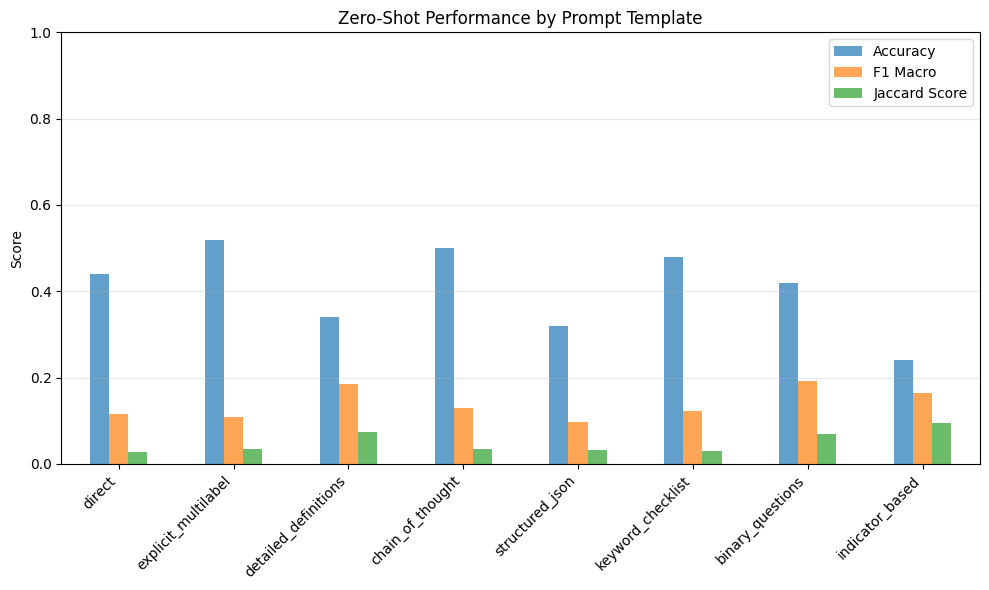

In [15]:
# Compare prompt performance
print("ZERO-SHOT RESULTS COMPARISON")

results_df = pd.DataFrame(zero_shot_results).T
print("\n" + results_df.round(3).to_string())

# Find best prompt
best_prompt = results_df['f1_macro'].idxmax()
best_f1 = results_df.loc[best_prompt, 'f1_macro']

print(f"\nBest prompt: '{best_prompt}'")
print(f"   F1 (macro): {best_f1:.3f}")

# Viz
fig, ax = plt.subplots(figsize=(10, 6))
results_df[['accuracy', 'f1_macro', 'jaccard']].plot(
    kind='bar',
    ax=ax,
    alpha=0.7
)
ax.set_ylabel('Score')
ax.set_title('Zero-Shot Performance by Prompt Template')
ax.set_ylim([0, 1])
ax.legend(['Accuracy', 'F1 Macro', 'Jaccard Score'])
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Reflection: Zero-Shot Prompt Engineering

{... write their reflections here...}

---
# Task 3: Few-Shot Evaluation (10 points)

Test if providing examples in the prompt improves performance.

In [16]:
# Reload generator
print(f"\nReloading model...")
generator = pipeline(
    "text-generation",
    model=MODEL_NAME,
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else -1,
    max_new_tokens=30,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)


Reloading model...


Device set to use cuda


### Select few-shot examples (one per class combination)


In [17]:

few_shot_examples = []

# Target different label combinations
target_combinations = [
    [1, 0, 0],  # Only Net Zero
    [0, 1, 0],  # Only Reduction
    [0, 0, 1],  # Only Other
    [1, 1, 0],  # Net Zero + Reduction
]

for target_labels in target_combinations:
    for ex in train_dataset:
        if list(ex['labels']) == target_labels:
            # Extract SHORT text (critical for context window)
            text_short = ex['text'][:70]  # Very short!

            # Get label names
            labels_present = [LABEL_NAMES[i] for i, val in enumerate(ex['labels']) if val == 1]
            if not labels_present:
                labels_present = ['None']

            few_shot_examples.append({
                'text': text_short,
                'labels': labels_present,
                'labels_array': ex['labels']
            })
            break

    if len(few_shot_examples) >= 4:
        break

print(f"\n✓ Selected {len(few_shot_examples)} examples:")
for i, ex in enumerate(few_shot_examples, 1):
    print(f"\n  Example {i}:")
    print(f"    Text: {ex['text']}...")
    print(f"    Labels: {', '.join(ex['labels'])}")
    print(f"    Pattern: {ex['labels_array']}")



✓ Selected 4 examples:

  Example 1:
    Text: As for attracting funds from the private sector, we will promote the d...
    Labels: Net Zero
    Pattern: [1.0, 0.0, 0.0]

  Example 2:
    Text: In November 2015 the country submitted its proposal to the UNFCCC for ...
    Labels: Reduction
    Pattern: [0.0, 1.0, 0.0]

  Example 3:
    Text:  Energy sector is the largest producer of greenhouse gas emissions and...
    Labels: Other
    Pattern: [0.0, 0.0, 1.0]

  Example 4:
    Text: Nationally Determined Contributions (2018). In 2018, RMI became the fi...
    Labels: Net Zero, Reduction
    Pattern: [1.0, 1.0, 0.0]


### Create few-shot prompt

In [18]:
# Create few-shot prompt templates
def create_few_shot_prompt(test_text, style='simple'):
    """
    Create few-shot prompts with different styles.

    Args:
        test_text: The text to classify
        style: 'simple', 'structured', 'explicit', or 'reasoning'
    """

    if style == 'simple':
        # Simple example format
        prompt = "Identify climate targets in policy texts. Multiple targets can be present.\n\n"

        for i, ex in enumerate(few_shot_examples, 1):
            prompt += f"Example {i}:\n"
            prompt += f"Text: {ex['text']}...\n"
            prompt += f"Targets: {', '.join(ex['labels'])}\n\n"

        prompt += f"Now classify:\n"
        prompt += f"Text: {test_text[:100]}...\n"
        prompt += f"Targets:"

    elif style == 'structured':
        # Structured YES/NO format
        prompt = "Classify climate targets. Mark each as Present or Absent.\n\n"

        for i, ex in enumerate(few_shot_examples, 1):
            prompt += f"Example {i}:\n"
            prompt += f"Text: {ex['text']}...\n"
            nz = 'Present' if ex['labels_array'][0] == 1 else 'Absent'
            rd = 'Present' if ex['labels_array'][1] == 1 else 'Absent'
            ot = 'Present' if ex['labels_array'][2] == 1 else 'Absent'
            prompt += f"Net Zero: {nz}, Reduction: {rd}, Other: {ot}\n\n"

        prompt += f"Now classify:\n"
        prompt += f"Text: {test_text[:100]}...\n"
        prompt += f"Net Zero:"

    elif style == 'explicit':
        # Explicit multi-label format
        prompt = "Multi-label classification: Check ALL targets that apply.\n\n"

        for i, ex in enumerate(few_shot_examples, 1):
            prompt += f"{i}. \"{ex['text']}...\"\n"
            prompt += f"   → {', '.join(ex['labels'])}\n\n"

        prompt += f"Now: \"{test_text[:100]}...\"\n"
        prompt += f"   →"

    elif style == 'reasoning':
        # Show reasoning process
        prompt = "Identify targets by checking for each type:\n\n"

        for i, ex in enumerate(few_shot_examples, 1):
            prompt += f"Text {i}: {ex['text']}...\n"

            # Show reasoning
            if ex['labels_array'][0] == 1:
                prompt += "  ✓ Net Zero (neutrality mentioned)\n"
            if ex['labels_array'][1] == 1:
                prompt += "  ✓ Reduction (percentage decrease)\n"
            if ex['labels_array'][2] == 1:
                prompt += "  ✓ Other (renewable/efficiency goal)\n"
            if sum(ex['labels_array']) == 0:
                prompt += "  ✗ None\n"

            prompt += f"  Result: {', '.join(ex['labels'])}\n\n"

        prompt += f"Text: {test_text[:1000]}...\n"
        prompt += f"Result:"

    return prompt


# Test different styles
test_text = test_dataset[0]['text']

for style in ['simple', 'structured', 'explicit', 'reasoning']:
    prompt = create_few_shot_prompt(test_text, style=style)
    print(f"\n--- Style: {style} ---")
    print(f"Length: {len(prompt)} chars")
    print(f"Preview:\n{prompt}...")


--- Style: simple ---
Length: 657 chars
Preview:
Identify climate targets in policy texts. Multiple targets can be present.

Example 1:
Text: As for attracting funds from the private sector, we will promote the d...
Targets: Net Zero

Example 2:
Text: In November 2015 the country submitted its proposal to the UNFCCC for ...
Targets: Reduction

Example 3:
Text:  Energy sector is the largest producer of greenhouse gas emissions and...
Targets: Other

Example 4:
Text: Nationally Determined Contributions (2018). In 2018, RMI became the fi...
Targets: Net Zero, Reduction

Now classify:
Text: (g) procedures for preventing fraudulent activity, including detection, handling and follow-up proce...
Targets:...

--- Style: structured ---
Length: 769 chars
Preview:
Classify climate targets. Mark each as Present or Absent.

Example 1:
Text: As for attracting funds from the private sector, we will promote the d...
Net Zero: Present, Reduction: Absent, Other: Absent

Example 2:
Text: In November 201

Since I defined a range of diff few-shot prompt structures, I need another parser.

In [19]:
def parse_few_shot_output(generated_text, prompt_style='simple'):
    """
    Parse few-shot outputs based on prompt style.
    Returns: [0/1, 0/1, 0/1] for [Net Zero, Reduction, Other]
    """
    text_lower = generated_text.lower()
    labels = [0, 0, 0]

    if prompt_style == 'structured':
        # Parse "Net Zero: Present, Reduction: Absent, Other: Present"
        if 'net zero: present' in text_lower or 'net zero:present' in text_lower:
            labels[0] = 1
        if 'reduction: present' in text_lower or 'reduction:present' in text_lower:
            labels[1] = 1
        if 'other: present' in text_lower or 'other:present' in text_lower:
            labels[2] = 1

    else:
        # Parse list format: "Net Zero, Reduction" or "Other" or "None"

        # Look for the answer section (after last example)
        answer_section = text_lower
        if 'result:' in text_lower:
            answer_section = text_lower.split('result:')[-1]
        elif 'targets:' in text_lower:
            answer_section = text_lower.split('targets:')[-1]
        elif '→' in text_lower:
            answer_section = text_lower.split('→')[-1]

        # Check for each label
        if 'net zero' in answer_section or 'net-zero' in answer_section:
            labels[0] = 1
        if 'reduction' in answer_section:
            labels[1] = 1
        if 'other' in answer_section:
            labels[2] = 1

        # Check for "none"
        if 'none' in answer_section and sum(labels) == 0:
            labels = [0, 0, 0]

    return labels

### Evaluate few shot learning

In [20]:
few_shot_results = {}

# Test different prompt styles
prompt_styles = ['simple', 'structured', 'explicit', 'reasoning']

for style in prompt_styles:
    print(f"\n--- Evaluating style: '{style}' ---")

    predictions = []
    true_labels = []

    for i, example in enumerate(test_sample):
        if (i + 1) % 20 == 0:
            print(f"  Processing {i+1}/{len(test_sample)}...", end='\r')

        prompt = create_few_shot_prompt(example['text'], style=style)

        try:
            output = generator(prompt, max_new_tokens=30, truncation=True)
            response = output[0]['generated_text'][len(prompt):].strip()
            pred = parse_few_shot_output(response, prompt_style=style)
        except Exception as e:
            pred = [0, 0, 0]

        predictions.append(pred)
        true_labels.append(example['labels'])

    print(f"  Processing {len(test_sample)}/{len(test_sample)}... Done!")

    # Calculate metrics
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    accuracy = accuracy_score(true_labels, predictions)
    f1_macro = f1_score(true_labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(true_labels, predictions, average='weighted', zero_division=0)
    hamming = hamming_loss(true_labels, predictions)
    jaccard = jaccard_score(true_labels, predictions, average='samples', zero_division=0)

    few_shot_results[style] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'hamming': hamming,
        'jaccard': jaccard
    }

    print(f"  Accuracy:      {accuracy:.3f}")
    print(f"  F1 (macro):    {f1_macro:.3f}")
    print(f"  Jaccard:       {jaccard:.3f}")

# Clean up
clear_memory()


--- Evaluating style: 'simple' ---
  Processing 100/100... Done!
  Accuracy:      0.200
  F1 (macro):    0.183
  Jaccard:       0.087

--- Evaluating style: 'structured' ---
  Processing 100/100... Done!
  Accuracy:      0.320
  F1 (macro):    0.207
  Jaccard:       0.100

--- Evaluating style: 'explicit' ---
  Processing 100/100... Done!
  Accuracy:      0.080
  F1 (macro):    0.155
  Jaccard:       0.085

--- Evaluating style: 'reasoning' ---
  Processing 100/100... Done!
  Accuracy:      0.340
  F1 (macro):    0.110
  Jaccard:       0.033
GPU Memory cleared: 0.01GB allocated, 0.02GB reserved


### Plot diff prompt styles within few-shot learning mode


            accuracy  f1_macro  f1_weighted  hamming  jaccard
simple          0.20     0.183        0.189    0.463    0.087
structured      0.32     0.207        0.227    0.317    0.100
explicit        0.08     0.155        0.149    0.483    0.085
reasoning       0.34     0.110        0.105    0.293    0.033

Best few-shot style: 'structured'
   F1 (macro): 0.207


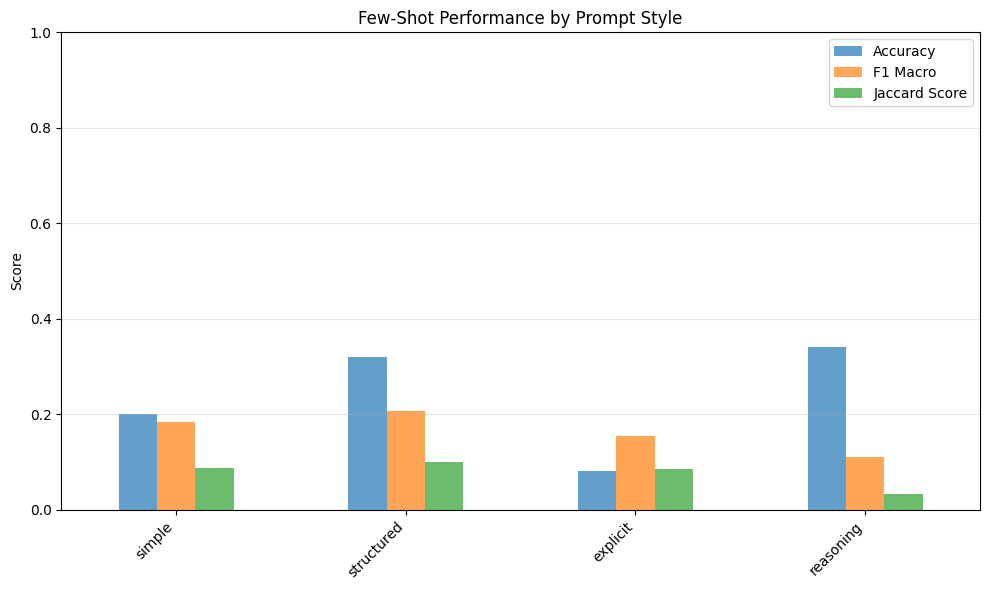

In [21]:
few_shot_df = pd.DataFrame(few_shot_results).T

print("\n" + few_shot_df.round(3).to_string())

# Find best few-shot style
best_few_shot_style = few_shot_df['f1_macro'].idxmax()
best_few_shot_f1 = few_shot_df.loc[best_few_shot_style, 'f1_macro']

print(f"\nBest few-shot style: '{best_few_shot_style}'")
print(f"   F1 (macro): {best_few_shot_f1:.3f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
few_shot_df[['accuracy', 'f1_macro', 'jaccard']].plot(
    kind='bar',
    ax=ax,
    alpha=0.7
)
ax.set_ylabel('Score')
ax.set_title('Few-Shot Performance by Prompt Style')
ax.set_ylim([0, 1])
ax.legend(['Accuracy', 'F1 Macro', 'Jaccard Score'])
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Zero-shot vs Few-shot


ZERO-SHOT vs FEW-SHOT COMPARISON

               Zero-Shot (Best)  Few-Shot (Best)  Difference  % Change
Accuracy                  0.420            0.320      -0.100     -23.8
F1 Macro                  0.193            0.207       0.014       7.2
Jaccard Score             0.068            0.100       0.032      46.3


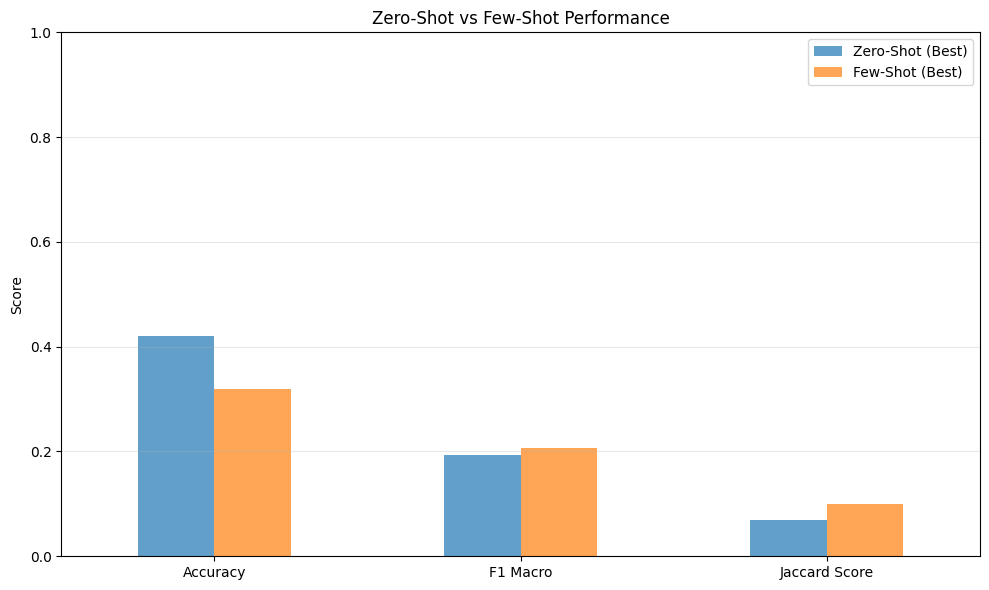


F1 (macro) change: +0.014 (+7.2%)


In [22]:
# Zero-shot vs Few-shot
print("\n" + "="*80)
print("ZERO-SHOT vs FEW-SHOT COMPARISON")
print("="*80)

comparison = pd.DataFrame({
    'Zero-Shot (Best)': [
        zero_shot_results[best_prompt]['accuracy'],
        zero_shot_results[best_prompt]['f1_macro'],
        zero_shot_results[best_prompt]['jaccard']
    ],
    'Few-Shot (Best)': [
        few_shot_results[best_few_shot_style]['accuracy'],
        few_shot_results[best_few_shot_style]['f1_macro'],
        few_shot_results[best_few_shot_style]['jaccard']
    ]
}, index=['Accuracy', 'F1 Macro', 'Jaccard Score'])

comparison['Difference'] = comparison['Few-Shot (Best)'] - comparison['Zero-Shot (Best)']
comparison['% Change'] = (comparison['Difference'] / comparison['Zero-Shot (Best)'] * 100).round(1)

print("\n" + comparison.round(3).to_string())

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
comparison[['Zero-Shot (Best)', 'Few-Shot (Best)']].plot(kind='bar', ax=ax, alpha=0.7)
ax.set_ylabel('Score')
ax.set_title('Zero-Shot vs Few-Shot Performance')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

improvement = few_shot_results[best_few_shot_style]['f1_macro'] - zero_shot_results[best_prompt]['f1_macro']
pct_improvement = (improvement / zero_shot_results[best_prompt]['f1_macro']) * 100

print(f"\nF1 (macro) change: {improvement:+.3f} ({pct_improvement:+.1f}%)")

# Reflection: Few-Shot Learning

.... their reflection here...

---
# Task 4: LoRA Fine-Tuning (15 points)

LoRA (Low-Rank Adaptation) is a parameter-efficient fine-tuning method that keeps the original pretrained model frozen and injects small trainable rank-decomposed matrices into its weight layers. Instead of updating all model parameters, it learns low-rank updates that approximate the weight changes needed for a new task. This drastically reduces memory and compute requirements while maintaining performance close to full fine-tuning.

**TODO**:
1. Prepare tokenized datasets
2. Load model for classification
3. Apply LoRA configuration
4. Train for 10 epochs
5. Plot learning curves
6. Evaluate on test set

In [23]:
# Prepare tokenized datasets
def tokenize_function(examples):
    """Tokenize texts and prepare multi-label format."""
    tokenized = tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512
    )
    # Convert labels to float for multi-label classification
    tokenized['labels'] = [[float(l) for l in labels] for labels in examples['labels']]
    return tokenized

print(f"\nTokenizing datasets...")

# Tokenize all splits
train_tokenized = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=train_dataset.column_names
)
val_tokenized = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=val_dataset.column_names
)
test_tokenized = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=test_dataset.column_names
)

train_tokenized.set_format('torch')
val_tokenized.set_format('torch')
test_tokenized.set_format('torch')

print(f"Tokenization complete")
print(f"  Train: {len(train_tokenized)} samples")
print(f"  Val:   {len(val_tokenized)} samples")
print(f"  Test:  {len(test_tokenized)} samples")


Tokenizing datasets...


Map:   0%|          | 0/1827 [00:00<?, ? examples/s]

Map:   0%|          | 0/391 [00:00<?, ? examples/s]

Map:   0%|          | 0/392 [00:00<?, ? examples/s]

Tokenization complete
  Train: 1827 samples
  Val:   391 samples
  Test:  392 samples


In [24]:
# Load model for classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"  # CRITICAL for multi-label
)
model.config.pad_token_id = tokenizer.pad_token_id

print(f"\n✓ {MODEL_NAME} loaded with {model.num_parameters():,} parameters")
print(f"  Classification head: {NUM_LABELS} labels (multi-label)")


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ gpt2 loaded with 124,442,112 parameters
  Classification head: 3 labels (multi-label)


In [25]:
# Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=TARGET_MODULES,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, lora_config)

print(f"\n✓ LoRA applied")
model.print_trainable_parameters()


✓ LoRA applied
trainable params: 813,312 || all params: 125,255,424 || trainable%: 0.6493


In [26]:
# Training configuration
training_args = TrainingArguments(
    output_dir="./climate_targets_gpt2_lora",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-4,
    weight_decay=0.01,
    warmup_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=25,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=SEED
)

print(f"\nTraining parameters:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Warmup steps: {training_args.warmup_steps}")
print(f"  Evaluation: Every epoch")
print(f"  FP16: {training_args.fp16}")


Training parameters:
  Epochs: 10
  Batch size: 8
  Learning rate: 0.0002
  Warmup steps: 100
  Evaluation: Every epoch
  FP16: True


In [27]:
# Define metrics function
def compute_metrics(eval_pred):
    """Calculate evaluation metrics for multi-label classification."""
    logits, labels = eval_pred

    # Use sigmoid + threshold for multi-label
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).float().numpy()

    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)
    hamming = hamming_loss(labels, predictions)
    jaccard = jaccard_score(labels, predictions, average='samples', zero_division=0)

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'hamming': hamming,
        'jaccard': jaccard
    }

In [28]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

### Training

In [29]:
# Train model
print("\n" + "="*80)
print(f"TRAINING FOR {NUM_EPOCHS} EPOCHS")
print("="*80)

train_result = trainer.train()

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"  Total time: {train_result.metrics['train_runtime']:.1f}s ({train_result.metrics['train_runtime']/60:.1f} min)")
print(f"  Training loss: {train_result.metrics['train_loss']:.4f}")
print(f"  Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")


TRAINING FOR 10 EPOCHS


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Hamming,Jaccard
1,0.359600,0.342432,0.664962,0.378080,0.471736,0.132992,0.157289
2,0.200600,0.237647,0.741688,0.535823,0.613204,0.099744,0.220801
3,0.161900,0.233162,0.777494,0.642933,0.700321,0.084399,0.285166
4,0.109500,0.268573,0.749361,0.729217,0.745098,0.098892,0.343564
5,0.113400,0.261464,0.774936,0.761668,0.782166,0.086104,0.355925
6,0.089100,0.197629,0.803069,0.760881,0.776070,0.075874,0.325234
7,0.088700,0.239121,0.805627,0.757565,0.770200,0.073316,0.300938
8,0.059800,0.255595,0.808184,0.766356,0.784499,0.074169,0.335465
9,0.080100,0.251474,0.803069,0.761987,0.779584,0.074169,0.320546
10,0.052300,0.254249,0.808184,0.768644,0.786489,0.070759,0.318841



TRAINING COMPLETE
  Total time: 811.1s (13.5 min)
  Training loss: 0.1794
  Samples/second: 22.53


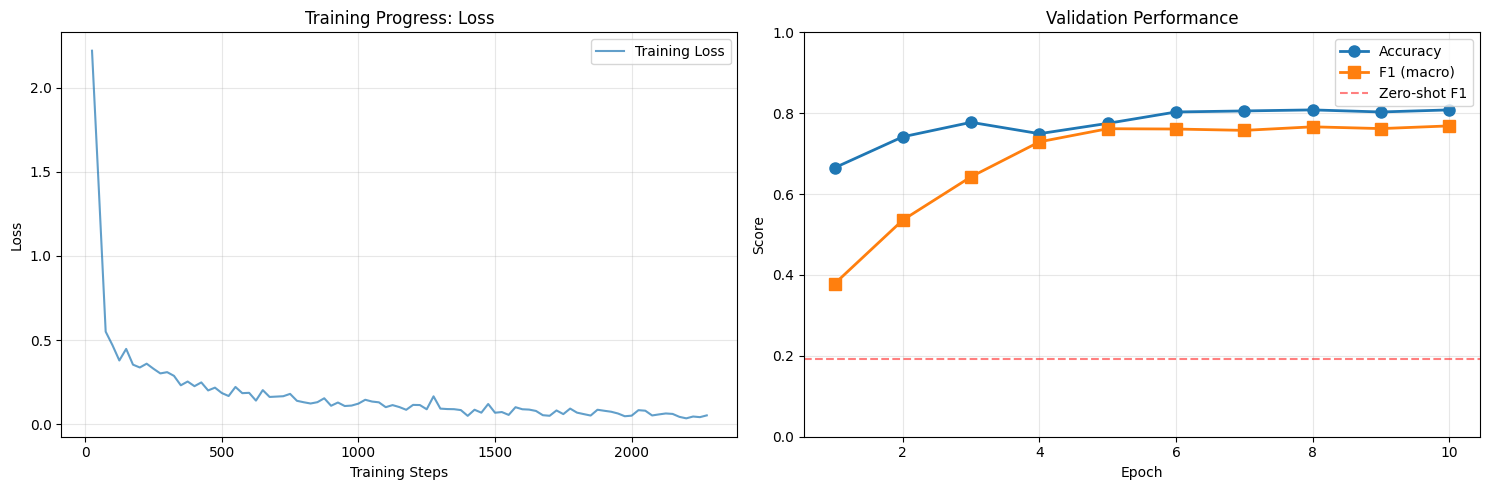


Learning curves show improvement


In [30]:
# Plot learning curves

log_history = trainer.state.log_history

# Extract training and validation metrics
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

if train_logs and eval_logs:
    # Training loss
    train_steps = [log['step'] for log in train_logs]
    train_loss = [log['loss'] for log in train_logs]

    # Validation metrics
    eval_epochs = [log['epoch'] for log in eval_logs]
    eval_loss = [log['eval_loss'] for log in eval_logs]
    eval_f1 = [log['eval_f1_macro'] for log in eval_logs]
    eval_acc = [log['eval_accuracy'] for log in eval_logs]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    axes[0].plot(train_steps, train_loss, label='Training Loss', alpha=0.7)
    # Map eval loss to steps (approximate)
    eval_steps = [step for step in train_steps if any(abs(step/len(train_steps)*NUM_EPOCHS - e) < 0.1 for e in eval_epochs)]
    if len(eval_steps) == len(eval_loss):
        axes[0].plot(eval_steps, eval_loss, label='Validation Loss', marker='o', markersize=6)
    axes[0].set_xlabel('Training Steps')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Progress: Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Validation metrics
    axes[1].plot(eval_epochs, eval_acc, marker='o', label='Accuracy', markersize=8, linewidth=2)
    axes[1].plot(eval_epochs, eval_f1, marker='s', label='F1 (macro)', markersize=8, linewidth=2)
    axes[1].axhline(y=zero_shot_results[best_prompt]['f1_macro'],
                    color='red', linestyle='--', alpha=0.5, label='Zero-shot F1')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Validation Performance')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    print(f"\nLearning curves show {'improvement' if eval_f1[-1] > eval_f1[0] else 'potential overfitting'}")


### Evaluate on test set

In [31]:
# Evaluate on test set
print("\n" + "="*80)
print("EVALUATING ON TEST SET")
print("="*80)

test_results = trainer.evaluate(test_tokenized)

print(f"\nTest Set Performance:")
print(f"  Accuracy:      {test_results['eval_accuracy']:.4f}")
print(f"  F1 (macro):    {test_results['eval_f1_macro']:.4f}")
print(f"  F1 (weighted): {test_results['eval_f1_weighted']:.4f}")

# Get predictions for detailed analysis
predictions_output = trainer.predict(test_tokenized)
predictions = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids


EVALUATING ON TEST SET



Test Set Performance:
  Accuracy:      0.8469
  F1 (macro):    0.8217
  F1 (weighted): 0.8220


# Task 5: Comprehensive Evaluation and Analysis (10 points)

Analyse model performance, identify error patterns, and reflect on findings.

Here's a possible set of programmatic solutions students could consider for write up.

In [32]:
# Get predictions correctly for multi-label
print("\n" + "="*80)
print("GETTING PREDICTIONS (MULTI-LABEL)")
print("="*80)

# Get raw predictions from model
predictions_output = trainer.predict(test_tokenized)

# CRITICAL: For multi-label, apply sigmoid + threshold
import torch
logits = predictions_output.predictions
predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).float().numpy()
true_labels = predictions_output.label_ids

print(f"\nPrediction shapes:")
print(f"  Logits shape:      {logits.shape}")
print(f"  Predictions shape: {predictions.shape}")
print(f"  True labels shape: {true_labels.shape}")

print(f"\nFirst 3 predictions:")
print(predictions[:3])
print(f"\nFirst 3 true labels:")
print(true_labels[:3])

print("\n✓ Predictions ready for evaluation")


GETTING PREDICTIONS (MULTI-LABEL)



Prediction shapes:
  Logits shape:      (392, 3)
  Predictions shape: (392, 3)
  True labels shape: (392, 3)

First 3 predictions:
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]

First 3 true labels:
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]

✓ Predictions ready for evaluation



PER-LABEL PERFORMANCE

--------------------------------------------------------------------------------
Label: Net Zero
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Absent      0.978     0.986     0.982       359
     Present      0.833     0.758     0.794        33

    accuracy                          0.967       392
   macro avg      0.906     0.872     0.888       392
weighted avg      0.966     0.967     0.966       392


--------------------------------------------------------------------------------
Label: Reduction
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Absent      0.973     0.985     0.979       329
     Present      0.915     0.857     0.885        63

    accuracy                          0.964       392
   macro avg      0.944     0.921     0.932       392
weighted avg      0

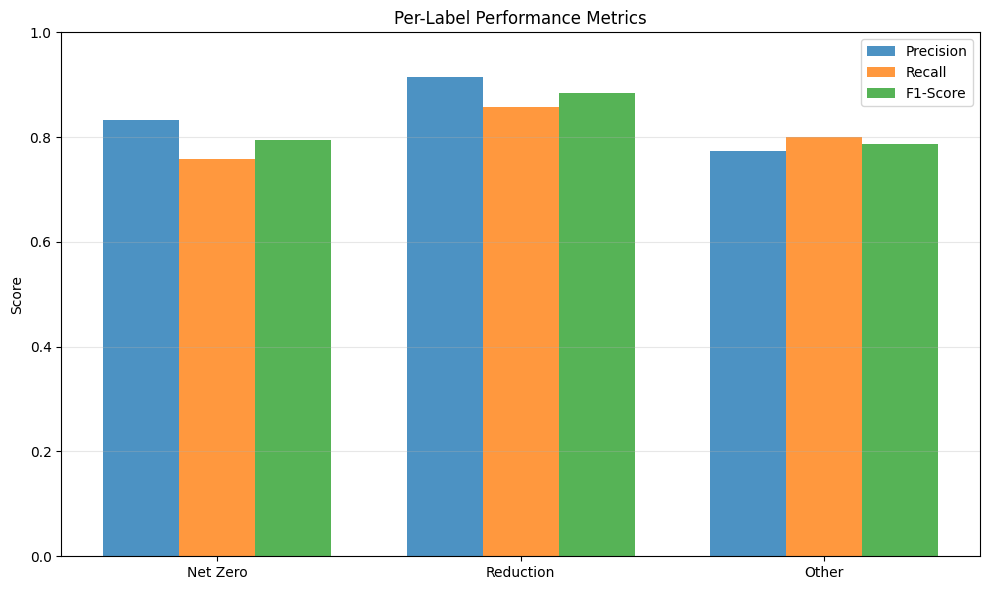

In [33]:
# Per-Label Performance (Multi-label)
print("\n" + "="*80)
print("PER-LABEL PERFORMANCE")
print("="*80)

for i, label_name in enumerate(LABEL_NAMES):
    print(f"\n{'-'*80}")
    print(f"Label: {label_name}")
    print(f"{'-'*80}")

    y_true = true_labels[:, i]
    y_pred = predictions[:, i]

    print(classification_report(
        y_true,
        y_pred,
        target_names=['Absent', 'Present'],
        digits=3,
        zero_division=0
    ))

# Overall multi-label metrics
print(f"\n{'='*80}")
print("OVERALL MULTI-LABEL METRICS")
print(f"{'='*80}")

print(f"\nExact Match Accuracy:  {accuracy_score(true_labels, predictions):.3f}")
print(f"F1 (macro):            {f1_score(true_labels, predictions, average='macro', zero_division=0):.3f}")
print(f"F1 (weighted):         {f1_score(true_labels, predictions, average='weighted', zero_division=0):.3f}")
print(f"F1 (samples):          {f1_score(true_labels, predictions, average='samples', zero_division=0):.3f}")
print(f"Hamming Loss:          {hamming_loss(true_labels, predictions):.3f}")
print(f"Jaccard Score:         {jaccard_score(true_labels, predictions, average='samples', zero_division=0):.3f}")

# Per-label metrics summary
print(f"\n{'-'*80}")
print("PER-LABEL SUMMARY")
print(f"{'-'*80}")

per_label_data = []
for i, label_name in enumerate(LABEL_NAMES):
    from sklearn.metrics import precision_score, recall_score

    precision = precision_score(true_labels[:, i], predictions[:, i], zero_division=0)
    recall = recall_score(true_labels[:, i], predictions[:, i], zero_division=0)
    f1 = f1_score(true_labels[:, i], predictions[:, i], zero_division=0)
    support = int(true_labels[:, i].sum())

    per_label_data.append({
        'Label': label_name,
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1-Score': f"{f1:.3f}",
        'Support': support
    })

per_label_df = pd.DataFrame(per_label_data)
print("\n" + per_label_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(LABEL_NAMES))
width = 0.25

precisions = [float(d['Precision']) for d in per_label_data]
recalls = [float(d['Recall']) for d in per_label_data]
f1s = [float(d['F1-Score']) for d in per_label_data]

ax.bar(x - width, precisions, width, label='Precision', alpha=0.8)
ax.bar(x, recalls, width, label='Recall', alpha=0.8)
ax.bar(x + width, f1s, width, label='F1-Score', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Per-Label Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(LABEL_NAMES)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

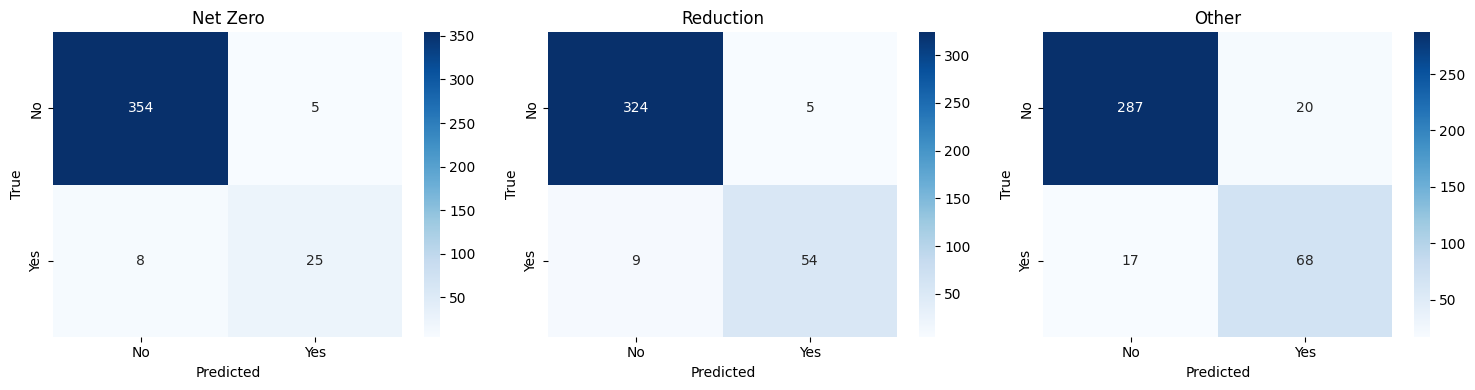


Confusion Matrix Insights:
  - Each subplot shows binary classification for one label
  - Diagonal = correct predictions, off-diagonal = errors
  - Look for: which labels are over/under-predicted?


In [34]:
# Multi-label confusion analysis
# For each label, create confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, label_name in enumerate(LABEL_NAMES):
    cm = confusion_matrix(true_labels[:, i], predictions[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'{label_name}')

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Insights:")
print("  - Each subplot shows binary classification for one label")
print("  - Diagonal = correct predictions, off-diagonal = errors")
print("  - Look for: which labels are over/under-predicted?")

In [35]:
# Identify error cases
print("\n" + "="*80)
print("ERROR ANALYSIS: MISCLASSIFIED EXAMPLES")
print("="*80)

# Find misclassified examples
errors = []
for i, (true, pred) in enumerate(zip(true_labels, predictions)):
    if not np.array_equal(true, pred):
        true_labels_list = [LABEL_NAMES[j] for j, val in enumerate(true) if val == 1]
        pred_labels_list = [LABEL_NAMES[j] for j, val in enumerate(pred) if val == 1]

        errors.append({
            'index': i,
            'text': test_dataset[i]['text'],
            'true_labels': true_labels_list if true_labels_list else ['None'],
            'pred_labels': pred_labels_list if pred_labels_list else ['None'],
            'true_array': true,
            'pred_array': pred
        })

print(f"\nTotal errors: {len(errors)} / {len(test_dataset)} ({len(errors)/len(test_dataset)*100:.1f}%)")

# Show 10 error examples
print("\n" + "="*80)
print("ERROR EXAMPLES (showing first 10)")
print("="*80)

for i, error in enumerate(errors[:10], 1):
    print(f"\n{'='*80}")
    print(f"Error {i}:")
    print(f"{'='*80}")
    print(f"Text: {error['text'][:300]}...")
    print(f"\nTrue labels:      {', '.join(error['true_labels'])}")
    print(f"Predicted labels: {', '.join(error['pred_labels'])}")

    # Analyze error type
    true_set = set(error['true_labels'])
    pred_set = set(error['pred_labels'])

    print(f"\nError type:")
    if len(pred_set & true_set) == 0:
        print("  → Complete miss: no overlap between true and predicted")
    elif len(pred_set - true_set) > 0 and len(true_set - pred_set) > 0:
        print(f"  → Partial error: missed {true_set - pred_set}, incorrectly added {pred_set - true_set}")
    elif len(pred_set - true_set) > 0:
        print(f"  → False positive: incorrectly added {pred_set - true_set}")
    elif len(true_set - pred_set) > 0:
        print(f"  → False negative: missed {true_set - pred_set}")


ERROR ANALYSIS: MISCLASSIFIED EXAMPLES

Total errors: 60 / 392 (15.3%)

ERROR EXAMPLES (showing first 10)

Error 1:
Text: In addition to the goals for 2030 and the policy measures required to achieve them, the national integrated energy and climate plan presents the impact of the decided policy measures on the estimated development course of greenhouse gas emissions, renewable energy and energy efficiency until 2040. T...

True labels:      Net Zero
Predicted labels: None

Error type:
  → Complete miss: no overlap between true and predicted

Error 2:
Text: All of the above measures would represent a total of 1,740 KTCO2/year avoided in 2030 compared to the BAU scenario All of the above measures would represent a total of 1,160 KTCO2/year avoided in 2030 compared to the unconditional scenario. Improving the efficiency of the national transport system...

True labels:      Reduction
Predicted labels: None

Error type:
  → Complete miss: no overlap between true and predicted

Error 3:
Te


               Error Category  Count  Percentage
False Negative (missed label)     14   23.333333
 False Positive (extra label)      7   11.666667
                Complete miss     39   65.000000
        Partial (mixed FP/FN)      0    0.000000


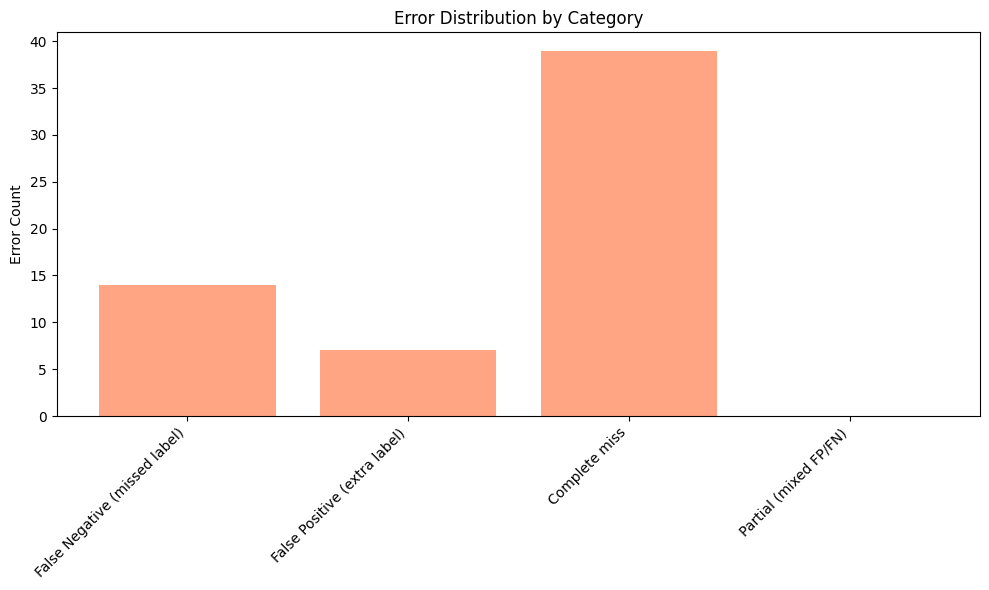

In [36]:
# Error taxonomy
# Categorize errors
error_categories = {
    'False Negative (missed label)': 0,
    'False Positive (extra label)': 0,
    'Complete miss': 0,
    'Partial (mixed FP/FN)': 0
}

for error in errors:
    true_set = set(error['true_labels'])
    pred_set = set(error['pred_labels'])

    if len(pred_set & true_set) == 0:
        error_categories['Complete miss'] += 1
    elif len(pred_set - true_set) > 0 and len(true_set - pred_set) > 0:
        error_categories['Partial (mixed FP/FN)'] += 1
    elif len(pred_set - true_set) > 0:
        error_categories['False Positive (extra label)'] += 1
    elif len(true_set - pred_set) > 0:
        error_categories['False Negative (missed label)'] += 1

# Create taxonomy table
taxonomy_df = pd.DataFrame({
    'Error Category': list(error_categories.keys()),
    'Count': list(error_categories.values()),
    'Percentage': [v/len(errors)*100 for v in error_categories.values()]
})

print("\n" + taxonomy_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(taxonomy_df['Error Category'], taxonomy_df['Count'], alpha=0.7, color='coral')
ax.set_ylabel('Error Count')
ax.set_title('Error Distribution by Category')
ax.tick_params(axis='x', rotation=45)
plt.xticks(ha='right')
plt.tight_layout()
plt.show()


               Approach  F1 Macro  Accuracy  Jaccard
     Zero-Shot (direct)     0.117     0.440    0.028
Zero-Shot (best prompt)     0.193     0.420    0.068
               Few-Shot     0.207     0.320    0.100
        LoRA Fine-Tuned     0.822     0.847    0.315


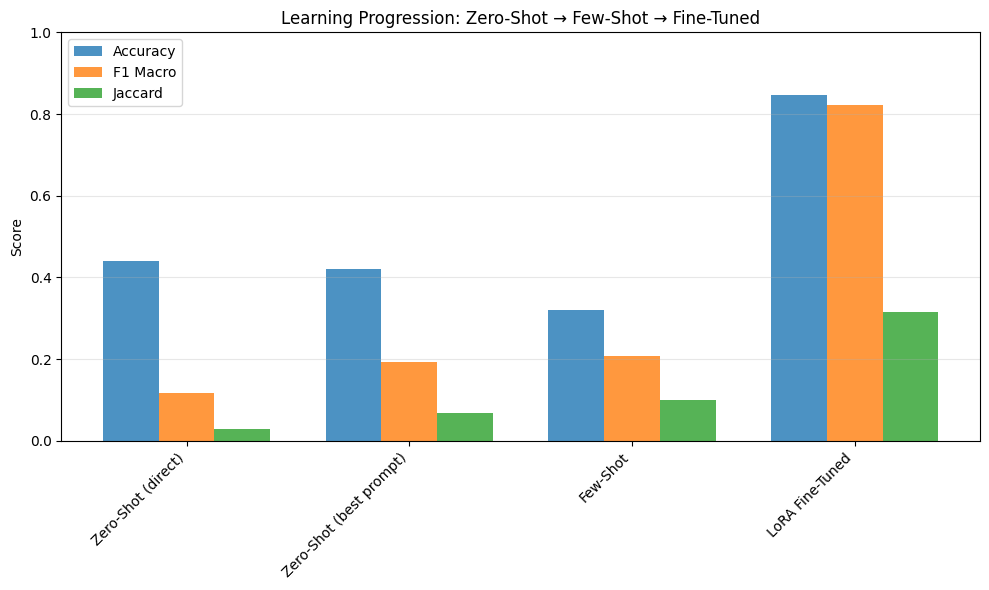


overall improvement: 0.705 F1
   (603.2% relative improvement)


In [37]:
# Final comparison: all approaches
final_comparison = pd.DataFrame({
    'Approach': [
        'Zero-Shot (direct)',
        'Zero-Shot (best prompt)',
        'Few-Shot',
        'LoRA Fine-Tuned'
    ],
    'F1 Macro': [
        zero_shot_results['direct']['f1_macro'],
        zero_shot_results[best_prompt]['f1_macro'],
        few_shot_results[best_few_shot_style]['f1_macro'],
        test_results['eval_f1_macro']
    ],
    'Accuracy': [
        zero_shot_results['direct']['accuracy'],
        zero_shot_results[best_prompt]['accuracy'],
        few_shot_results[best_few_shot_style]['accuracy'],
        test_results['eval_accuracy']
    ],
    'Jaccard': [
        zero_shot_results['direct']['jaccard'],
        zero_shot_results[best_prompt]['jaccard'],
        few_shot_results[best_few_shot_style]['jaccard'],
        test_results['eval_jaccard']
    ]
})

print("\n" + final_comparison.round(3).to_string(index=False))

# Visualize progression
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(final_comparison))
width = 0.25

ax.bar(x - width, final_comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x, final_comparison['F1 Macro'], width, label='F1 Macro', alpha=0.8)
ax.bar(x + width, final_comparison['Jaccard'], width, label='Jaccard', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Learning Progression: Zero-Shot → Few-Shot → Fine-Tuned')
ax.set_xticks(x)
ax.set_xticklabels(final_comparison['Approach'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\noverall improvement: {test_results['eval_f1_macro'] - zero_shot_results['direct']['f1_macro']:.3f} F1")
print(f"   ({(test_results['eval_f1_macro'] / zero_shot_results['direct']['f1_macro'] - 1)*100:.1f}% relative improvement)")

### Comprehensive Reflection

...